<a href="https://colab.research.google.com/github/keside/Internet-of-Things-Sub-Metering-Analysis-/blob/master/iot_exploratiory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IOT Project


Project description:


*The aim of this project is to provide to clients of the Sub-meters company the benefits of sub-meters with data insights. Our hyphotesis is if those clients are actually going to save electricity using the sub-meters. The data that we have is the electric power consumption in one French household with a different minute sampling over a period of 4 years. We have three different sub-meters in different rooms which represent around the 50% electricity consumption of the house.*

I develop three different time series regression models and work with seasonal and non-seasonal forecasting.




In [0]:
%load_ext rpy2.ipython


## Loading Library


In [0]:
%load_ext rpy2.ipython

In [0]:
%%R
library(tidyverse)
library(lubridate)
install.packages("VIM")
library(VIM)
library(plotly)
install.packages("ggplot2")
install.packages("ggfortify")
library(ggplot2)
library(ggfortify)
install.packages("broom")
library(broom) #Tidy statistical summary output
install.packages("forecast")
library(forecast)
install.packages("broom")
library(broom)
# Plot_ly account
Sys.setenv("plotly_username"="akano")
Sys.setenv("plotly_api_key"="ZrMv1Oco8t12d23IhAGE")



***Reading CSV ***

In [0]:
%%R
DF <- read.csv("/content/df.csv")
summary(DF)
str(DF)
dim(DF)



Loading Energy Data and renaming them according to specification for easy understand and Analysis

In [0]:
%%R
Energy <-read.csv("/content/power.csv")

# Renamed the Meters for easy identification
newDF<- Energy %>% dplyr::rename(Kitchen_stuff=Sub_metering_1, Laundry=Sub_metering_2, w_heater_AC=Sub_metering_3)

# Coverted the Energy used to KWH and substracted meters to get my Remaining Energy
newDF$Global_active_power <- newDF$Global_active_power * 1000/60

newDF <- newDF %>%
  mutate(Engy_remain=Global_active_power -
           `Kitchen_stuff` - `Laundry` - `w_heater_AC`)
str(newDF)




***PreProcessing ***

In [0]:
%%R
## Combine Date and Time attribute values in a new attribute column

newDF <-cbind(newDF,paste(newDF$Date,newDF$Time),stringsAsFactors=FALSE)
colnames(newDF)[8] = "DateTime"


## Move the DateTime attribute within the dataset/ seperating Date and Time

newDF <- newDF[,c(ncol(newDF), 1:(ncol(newDF)-1))]

head(newDF)





**Coverting DateTime to POSIXlt to POSIXct**

In [0]:
%%R
newDF$DateTime <- as.POSIXct(newDF$DateTime, "%Y/%m/%d %H:%M:%S")


## Add the time zone
attr(newDF$DateTime, "tzone") <- "Europe/Paris" # Get or set specific attributes of an object.

newDF <- filter(newDF,year(DateTime) != 2006)  # Removed Year 2006 since it contains only two weeks info.

str(newDF)

Exploring "newDF" dataset Visualization

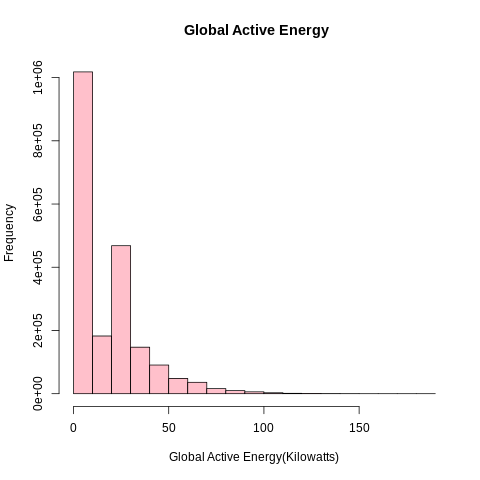

In [0]:
%%R
hist(newDF$Global_active_power, col="pink", main= " Global Active Energy", xlab= "Global Active Energy(Kilowatts)")

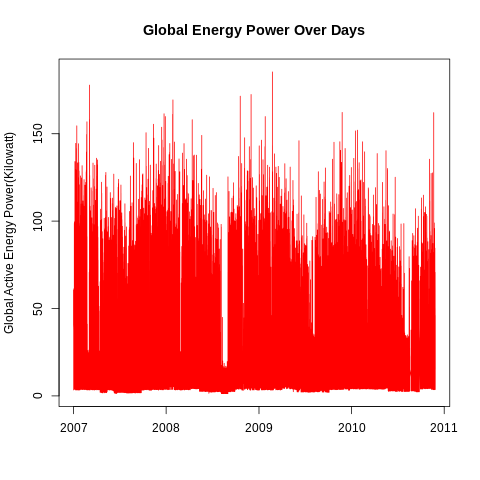

In [0]:
%%R
plot(newDF, Global_active_power~DateTime, col= "red", type="l",
     main= "Global Energy Power Over Days", ylab="Global Active Energy Power(Kilowatt)", xlab="")

**Yearly Consumption  **

In [0]:
%%R

newDF_tidy <- newDF %>% gather(meter, KWH, `Kitchen_stuff`,`Laundry`, `w_heater_AC`)
str(newDF_tidy)
newDF_tidy$meter <- factor(newDF_tidy$meter)

newDF_tidy$meter <- factor(newDF_tidy$meter)


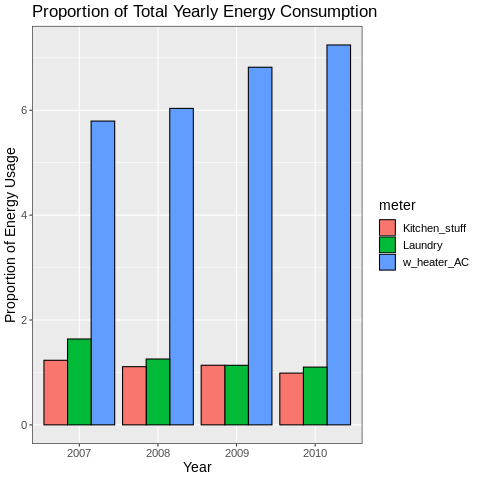

In [0]:
%%R

newDF_tidy%>%
  group_by(year(DateTime), meter) %>%
  summarise(sum=mean(KWH)) %>%
  ggplot(aes(x=factor(`year(DateTime)`), sum, group=meter,fill=meter)) +
  labs(x='Year', y='Proportion of Energy Usage') +
  ggtitle('Proportion of Total Yearly Energy Consumption') +
  geom_bar(stat='identity', position='dodge', color='black') +
  theme(panel.border=element_rect(colour='black', fill=NA)) +
  theme(text = element_text(size = 14))



**Quarterly Comsumption**

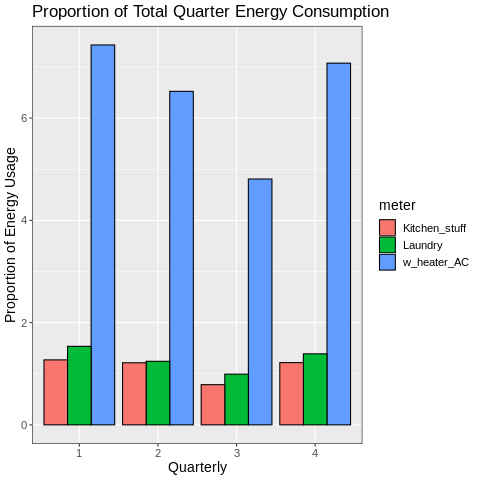

In [0]:
%%R
newDF_tidy %>%
filter(quarter(DateTime)<2011) %>%
  mutate(quarter=lubridate::year(DateTime)) %>%
   group_by(quarter(DateTime), meter) %>%
  summarise(sum=mean(KWH)) %>%
  ggplot(aes(x=factor(`quarter(DateTime)`), sum, group = meter, fill = meter)) +
  labs(x='Quarterly', y='Proportion of Energy Usage') +
  ggtitle('Proportion of Total Quarter Energy Consumption') +
  geom_bar(stat='identity', position='dodge', color='black') +
  theme(panel.border=element_rect(colour='black', fill=NA)) +
  theme(text = element_text(size = 14))

**Monthly Consumption**

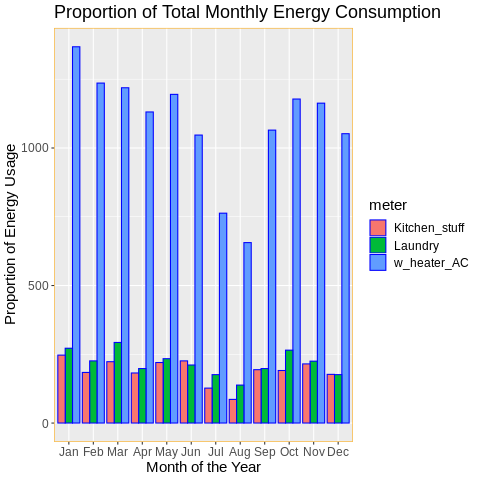

In [0]:
%%R

#Monthly Consumption

newDF_tidy %>%
  filter(year(DateTime)<2011) %>%
  mutate(Month=lubridate::month(DateTime, label=TRUE, abbr=TRUE)) %>%
  group_by(Month, meter) %>%
  summarise(sum=round(sum(KWH)/1000),2) %>%
  ggplot(aes(x=factor(Month), y=sum)) +
    labs(x='Month of the Year', y='Proportion of Energy Usage') + 
    ggtitle('Proportion of Total Monthly Energy Consumption') +
    geom_bar(stat='identity', position="dodge", aes(fill = meter), colour='blue') +
    theme(panel.border=element_rect(colour='orange', fill=NA)) +
    theme(text = element_text(size = 15))

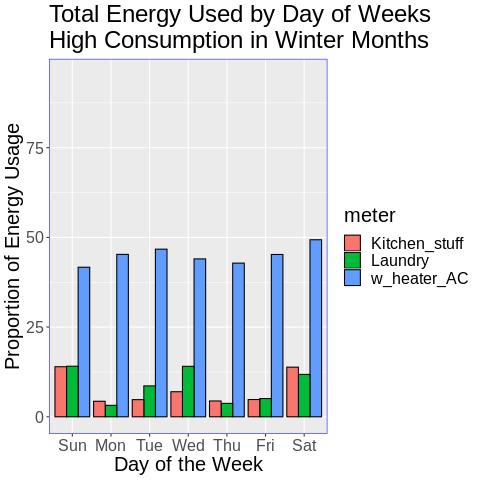

In [0]:
%%R

# Weekly Conssumption
newDF_tidy %>%
  filter(week(DateTime) == c(1:8)) %>%
  mutate(Day=lubridate::wday(DateTime, label=TRUE, abbr=TRUE)) %>%
  group_by(Day, meter) %>%
  summarise(sum=sum(KWH/1000)) %>%
  ggplot(aes(x=factor(Day), y=sum)) +
  labs(x='Day of the Week', y='Proportion of Energy Usage') +
  ylim(0,95) +
  ggtitle('Total Energy Used by Day of Weeks \nHigh Consumption in Winter Months') +
  geom_bar(position= "dodge",stat="identity", aes(fill = meter), colour='Black') +
  theme(panel.border=element_rect(colour='Blue', fill=NA)) +
  theme(text = element_text(size = 20))

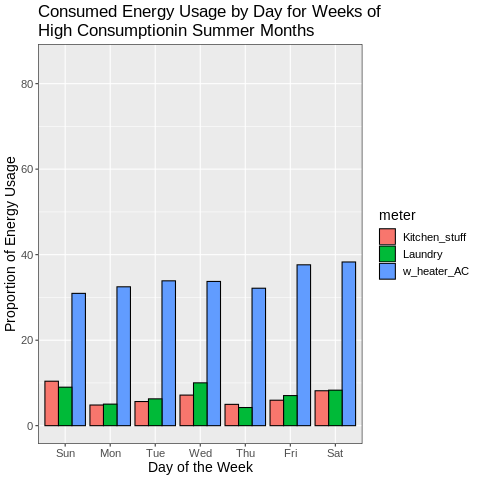

In [0]:
%%R
newDF_tidy %>%
  filter(week(DateTime) == c(20:28)) %>%
  mutate(Day=lubridate::wday(DateTime, label=TRUE, abbr=TRUE)) %>%
  group_by(Day, meter) %>%
  summarise(sum=sum(KWH/1000)) %>%
  ggplot(aes(x=factor(Day), y=sum)) +
  labs(x='Day of the Week', y='Proportion of Energy Usage') +
  ylim(0,85) +
  ggtitle('Consumed Energy Usage by Day for Weeks of \nHigh Consumption in Summer Months') +
  geom_bar(position= "dodge",stat='identity', aes(fill = meter), colour='black') +
  theme(panel.border=element_rect(colour='black', fill=NA)) +
  theme(text = element_text(size = 14))

Creating Yearly, Quarterly, Monthly and Weekly dataframe of the Sub-Meters.


Yearly ( ARIMA Model)

In [0]:
%%R
Power_yearly <- sum(newDF, week== 1, hour==10, minute==10)  %>% 
group_by(year(DateTime), week(DateTime)) 



str(Power_yearly)

In [0]:
%%R
Data_mth <- newDF %>% group_by(year(DateTime), month(DateTime)) %>%
summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000), 3),
            Laundry=round(sum(`Laundry`/1000), 3),
            w_heater_AC=round(sum(`w_heater_AC`/1000), 3),
            Engy_remain=round(sum(`Engy_remain`/1000), 3),
           Global_active_power=round(sum(`Global_active_power`/1000), 3))
         


 str(Data_mth) 
#write.csv(Data_mth, 'mth.data.csv')  

In [0]:
%%R
Data_qtr <- newDF %>% group_by(year(DateTime), quarter(DateTime)) %>%
summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000), 3),
            Laundry=round(sum(`Laundry`/1000), 3),
            w_heater_AC=round(sum(`w_heater_AC`/1000), 3),
            Engy_remain=round(sum(`Engy_remain`/1000), 3),
           Global_active_power=round(sum(`Global_active_power`/1000), 3))

write.csv(Data_qtr, 'Qtr.data.csv')  

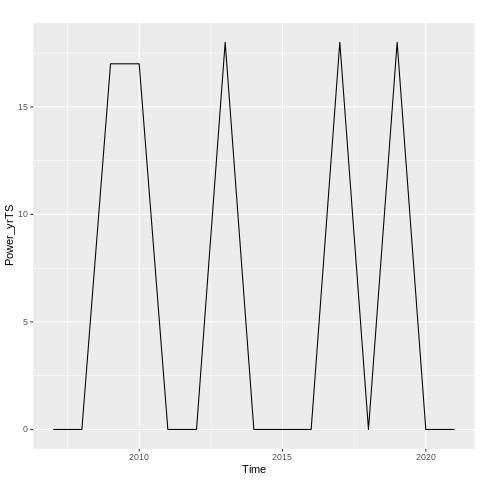

In [0]:
%%R
#Creating a TS 
Power_yrTS <- ts(Power_yearly$w_heater_AC, frequency=1, start=c(2007,1), end=c(2010,12))

#Plot
autoplot(Power_yrTS)

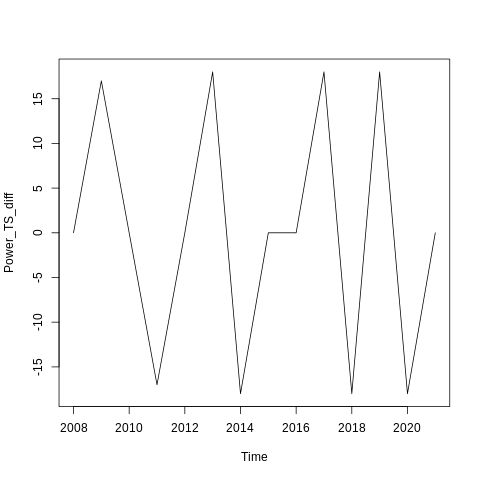

In [0]:
%%R
# Use the diff function to create a year to year in my dataset
Power_TS_diff <- diff(Power_yrTS, 1)

plot.ts(Power_TS_diff)


In [0]:
%%R
#Use the Arima Model for modelling
Power_TS_AR <- auto.arima(Power_yrTS, d=1, D=1, stepwise=FALSE, approximation=FALSE,trace=TRUE)

print(summary(Power_TS_AR))

checkresiduals(Power_TS_AR)


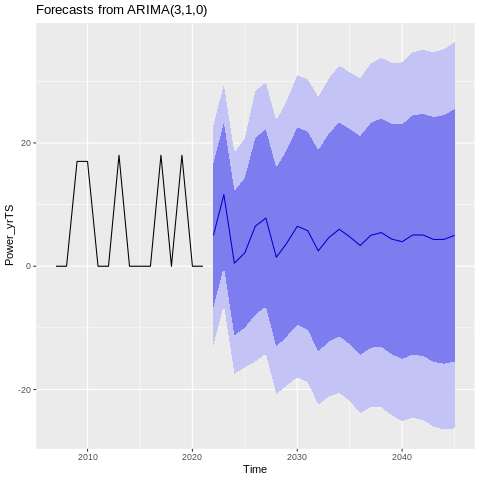

In [0]:
%%R
#Finally Forecast using my model
fcst<- forecast(Power_TS_AR, h= 24)
autoplot(fcst, include=36)

Quarterly using ARIMA 

In [0]:
%%R

#Subset data by quarter and summarise total usage across the 3 submeters
Power_qtr <- filter(newDF, year==2007, wday==1, hour==10, minute==10)  %>% 
group_by(year(DateTime), quarter(DateTime))

        
  
#-Look at top several rows of new quarterly data set 
head(Power_qtr)



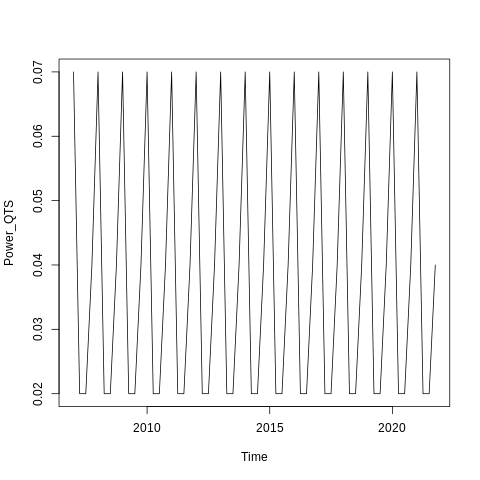

In [0]:
%%R
#Converting to TS using Water Heater
Power_QTS<- ts(Power_qtr$w_heater_AC, frequency=4, start=c(2007,1), end=c(2010,48))

#Plot
#autoplot(Power_QTS)
plot.ts(Power_QTS)

In [0]:
%%R
#We create a year to year in Quarter to remove trend
PowerQ_diff <- diff(Power_QTS, 4)

#Plot
autoplot(PowerQ_diff) 

In [0]:
%%R
# Forecast using Arima Model
Power_QTS_AR <- auto.arima(Power_QTS, d=1, D=1, stepwise=FALSE, approximation=FALSE,trace=TRUE)

print(summary(Power_QTS_AR))
checkresiduals(Power_QTS_AR)



In [0]:
%%R
#Finally, let use arima Model to forecast

F_AR <- forecast(Power_QTS_AR, h=24)
autoplot(F_AR, include=36)

In [0]:
%%R
Power_mnth <- newDF %>%
  group_by(year(DateTime), month(DateTime)) %>%
  summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000), 3),
            Laundry=round(sum(`Laundry`/1000), 3),
            w_heater_AC=round(sum(`w_heater_AC`/1000), 3))

head(Power_mnth)


# A tibble: 6 x 5
# Groups:   year(DateTime) [1]
  `year(DateTime)` `month(DateTime)` Kitchen_stuff Laundry w_heater_AC
             <int>             <int>         <dbl>   <dbl>       <dbl>
1             2007                 1          56.4    79.3        330.
2             2007                 2          47.6    64.6        270.
3             2007                 3          60.8   105.         288.
4             2007                 4          41.6    38.4        192.
5             2007                 5          76.2    72.2        229.
6             2007                 6          59.7    70.0        190.


Monthly using Arima

In [0]:
%%R
Power_Qtr<- newDF %>%
  group_by(year(DateTime), quarter(DateTime)) %>%
  summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000), 3),
            Laundry=round(sum(`Laundry`/1000), 3),
            w_heater_AC=round(sum(`w_heater_AC`/1000), 3))
  
  head(Power_Qtr)

# A tibble: 6 x 5
# Groups:   year(DateTime) [2]
  `year(DateTime)` `quarter(DateTime)` Kitchen_stuff Laundry w_heater_AC
             <int>               <int>         <dbl>   <dbl>       <dbl>
1             2007                   1          165.    249.        889.
2             2007                   2          177.    181.        610.
3             2007                   3          132.    181.        605.
4             2007                   4          168.    245.        919.
5             2008                   1          165.    199.        847.
6             2008                   2          169.    193.        878.


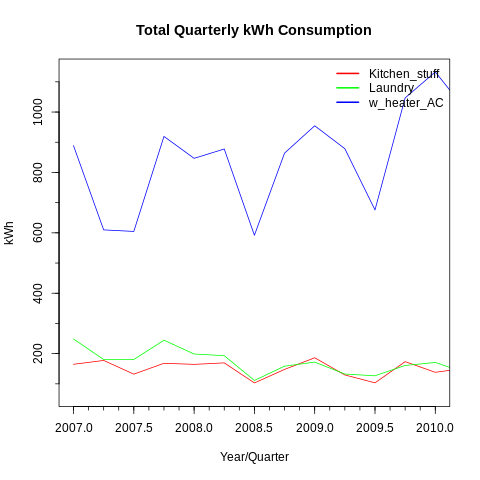

In [0]:
%%R
#Quarterly time series 
Power_QtrTS <- ts(Power_Qtr[,3:5],
                     frequency=4,
                     start=c(2007,1),
                     end=c(2010,4))



#-Plot monthly time series
plot(Power_QtrTS, 
     plot.type='s',
     xlim=c(2007, 2010),
     col=c('red', 'green', 'blue'),
     main='Total Quarterly kWh Consumption',
     xlab='Year/Quarter', ylab = 'kWh')
minor.tick(nx=4)
label <- c('Kitchen_stuff', 'Laundry', 'w_heater_AC')
legend('topright', label, col=c('red', 'green', 'blue'), lwd=2, bty='n')



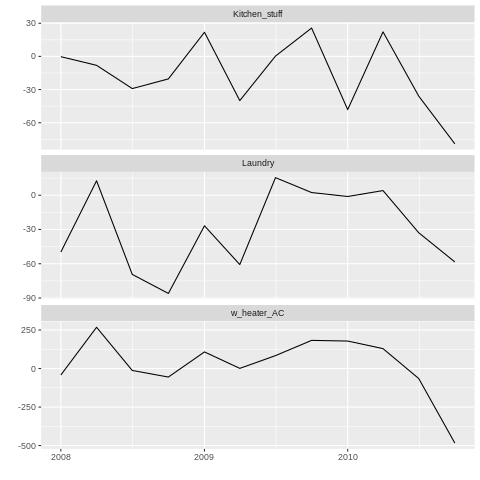

In [0]:
%%R
Power_QtrTS_diff <- diff(Power_QtrTS, 4)

autoplot(Power_QtrTS_diff)

In [0]:
%%R

Power_week<- newDF %>%
  group_by(year(DateTime), week(DateTime)) %>%
  summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000), 3),
            Laundry=round(sum(`Laundry`/1000), 3),
            w_heater_AC=round(sum(`w_heater_AC`/1000), 3))
  
  head(Power_Day)

Power_weekTS <- ts(Power_Day[,3:5],
                     frequency=366,
                     start=c(2007,1),
                     end=c(2010,12))



#-Plot weekly time series
plot(Power_weekTS, 
     plot.type='s',
     xlim=c(2007, 2010),
     col=c('red', 'green', 'blue'),
     main='Total Weekly kWh Consumption',
     xlab='Year/Weekly', ylab = 'kWh')
minor.tick(nx=7)
label <- c('Kitchen_stuff', 'Laundry', 'w_heater_AC')
legend('topright', label, col=c('red', 'green', 'blue'), lwd=2, bty='n')


In [0]:
%%R
Power_mth <- filter(newDF, week==2, hour==20) %>% 
group_by(year(DateTime) , month(DateTime)) %>% 
summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000),2),
          Laundry=round(sum(`Laundry`/1000),2), 
          w_heater_AC=round(sum(`w_heater_AC`/1000),2),
          Engy_remain=round(sum(`Engy_remain`/1000),2))

tail(Power_mth)


#Monthly time series 
Power_mthTS <- ts(Power_mth[,3:5],
                     frequency=12,
                     start=c(2007,1),
                     end=c(2010,11))
#head(Power_mthTS)


#-Plot monthly time series
plot(Power_mthTS, 
     plot.type='s',
     xlim=c(2007, 2010),
     col=c('red', 'green', 'blue'),
     main='Total Monthly kWh Consumption',
     xlab='Year/Month', ylab = 'kWh')
minor.tick(nx=12)
label <- c('Kitchen_stuff', 'Laundry', 'w_heater_AC')
legend('topleft', label, col=c('red', 'green', 'blue'), lwd=2, bty='n')


# A tibble: 4 x 6
# Groups:   year(DateTime) [4]
  `year(DateTime)` `month(DateTime… Kitchen_stuff Laundry w_heater_AC
             <int>            <int>         <dbl>   <dbl>       <dbl>
1             2007                1          0.77    1.2         6.1 
2             2008                1          0.7     0.07        2.43
3             2009                1          3.44    1.06        1.78
4             2010                1          0.53    0.72        1.62
# … with 1 more variable: Engy_remain <dbl>


**Quarterly Time series on Meters **

In [0]:
%%R
#-Create Quarterly time series 

#Power_qtrTS <- ts(Power_qtr[,3:5],
                     #frequency=4,
                     #start=c(2007,1),
                     #end=c(2010,4))


Power_qtrTS <- ts(Power_qtr$Kitchen_stuff,
                     frequency=4,
                     start=c(2007,1),
                     end=c(2010,4))

summary(Power_qtrTS)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.720   1.772   2.010   2.005   2.243   2.280 


2009 Quarterly Time Series Plot

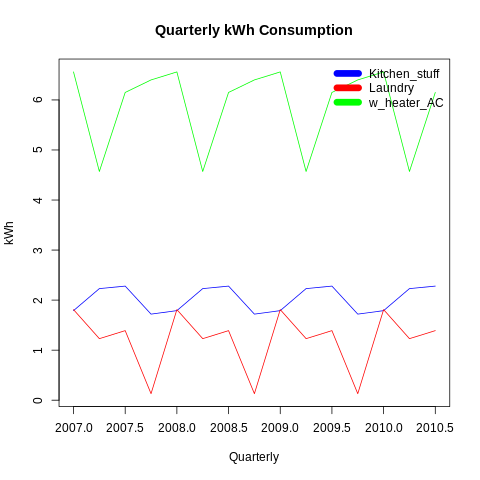

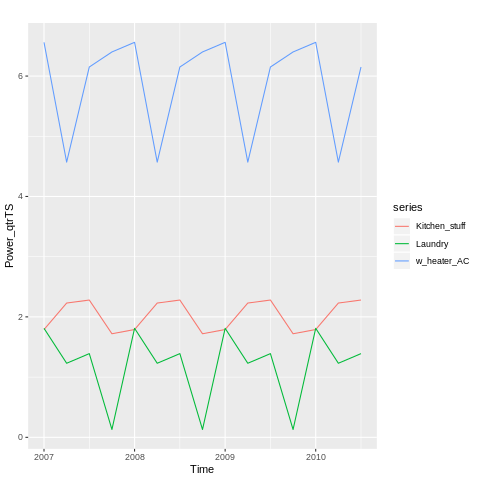

In [0]:
%%R
# Quarterly time series plot
plot(Power_qtrTS, 
     plot.type='s',
     col=c('blue',"red", 'green'),
     main='Quarterly kWh Consumption',
     xlab='Quarterly', ylab = 'kWh')

label <- c("Kitchen_stuff", 'Laundry','w_heater_AC')
legend('topright', label, col=c('blue', 'red', 'green'), lwd=9, bty='n')


autoplot(Power_qtrTS)



**Monthly Time Series on the Sub-Meters**

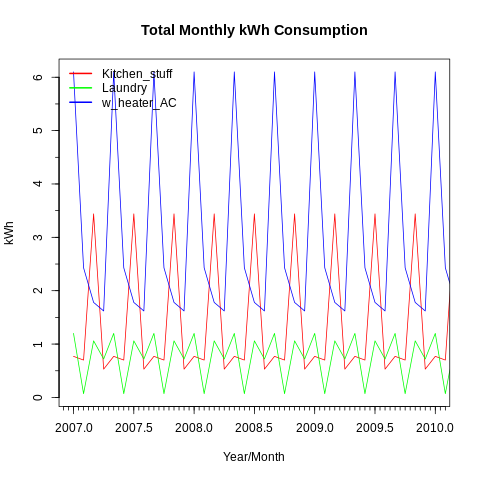

In [0]:
%%R
#Monthly time series 
Power_mthTS <- ts(Power_mth[,3:5],
                     frequency=12,
                     start=c(2007,1),
                     end=c(2010,11))
#head(Power_mthTS)


#-Plot monthly time series
plot(Power_mthTS, 
     plot.type='s',
     xlim=c(2007, 2010),
     col=c('red', 'green', 'blue'),
     main='Total Monthly kWh Consumption',
     xlab='Year/Month', ylab = 'kWh')
minor.tick(nx=12)
label <- c('Kitchen_stuff', 'Laundry', 'w_heater_AC')
legend('topleft', label, col=c('red', 'green', 'blue'), lwd=2, bty='n')


Weekly using ARIMA 

In [0]:
%%R
Power_wk <- filter(newDF, wday==2, hour==20, minute==1) %>% 
group_by(year(DateTime),month(DateTime), wday(DateTime)) %>% 
summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000),2),
          Laundry=round(sum(`Laundry`/1000),2), 
          w_heater_AC=round(sum(`w_heater_AC`/1000),2))

head(Power_wk)






# A tibble: 6 x 6
# Groups:   year(DateTime), month(DateTime) [6]
  `year(DateTime)` `month(DateTime… `wday(DateTime)` Kitchen_stuff Laundry
             <dbl>            <dbl>            <dbl>         <dbl>   <dbl>
1             2006               12                2             0    0   
2             2007                1                2             0    0   
3             2007                2                2             0    0.04
4             2007                3                2             0    0.04
5             2007                4                2             0    0   
6             2007                5                2             0    0   
# … with 1 more variable: w_heater_AC <dbl>


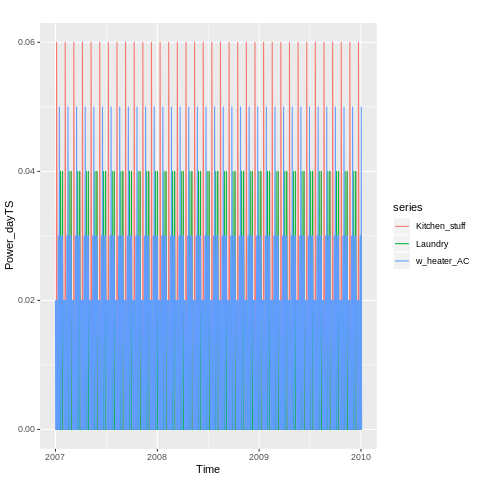

In [0]:
%%R
Power_day <- filter(newDF, year==2007, wday==5, hour==20, minute==0) %>% 
group_by(year(DateTime), day(DateTime)) %>% 
summarise(Kitchen_stuff=round(sum(`Kitchen_stuff`/1000),2),
          Laundry=round(sum(`Laundry`/1000),2), 
          w_heater_AC=round(sum(`w_heater_AC`/1000),2))

head(Power_day)
#Weekly time series 
Power_dayTS <- ts(Power_day[,3:5],
                     frequency = 366,
                     start=c(2007,1),
                     end=c(2010,3))
head(Power_dayTS)

#Time series plot for daily 
autoplot(Power_dayTS)

In [0]:
%%R
fit1 <-tslm(Power_QtrTS[,1] ~ trend + season)
#tidy(fit1)
summary(fit1)

In [0]:
%%R
fit1M2 <-tslm(Power_QtrTS[,2] ~ trend + season)
#tidy(fit1)
## Create the forecast for sub-meter 3. Forecast ahead 20 time periods 
forecastfitSM3 <- forecast(fitM2, h=20)
## Plot the forecast for sub-meter 3. 
plot(forecastfitSM2)

** Applying time series linear regression to the w_heater_AC

In [0]:
%%R
fit1 <- tslm(Power_QtrTS[,3] ~ trend + season)
#summary(fit1)
#glance(fit1)
#tidy(fit1)

## Create the forecast for sub-meter 3. Forecast ahead 20 time periods 
forecastfitSM3 <- forecast(fit1, h=20)
## Plot the forecast for sub-meter 3. 
plot(forecastfitS3)

In [0]:
%%R
fit2 <- tslm(Power_mthTS[,3] ~ trend + season)
summary(fit2)
#glance(fit2) 
#tidy(fit2)

## Create the forecast for sub-meter 3. Forecast ahead 20 time periods 
forecastfitSM3 <- forecast(fitSM3, h=20)
## Plot the forecast for sub-meter 3. 
plot(forecastfitSM3)

  

In [0]:
%%R
fit3 <- tslm(Power_wkTS~trend + season)
summary(fit3)
#glance(fit3)
#tidy(fit3)



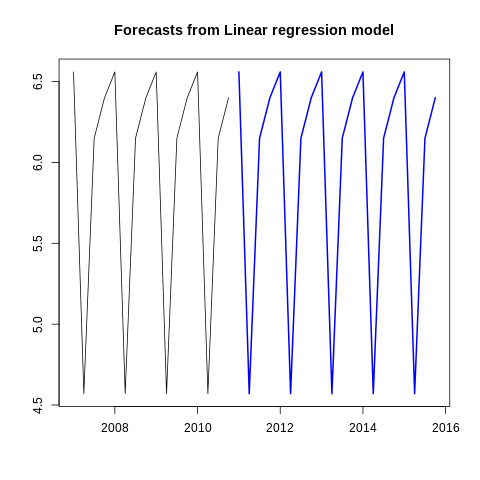

In [0]:
%%R
#Now lets create and plot a Quarterly, Monthly and Weekly forecast
forecastfit1 <- forecast(fit1, h=20)
plot(forecastfit1)

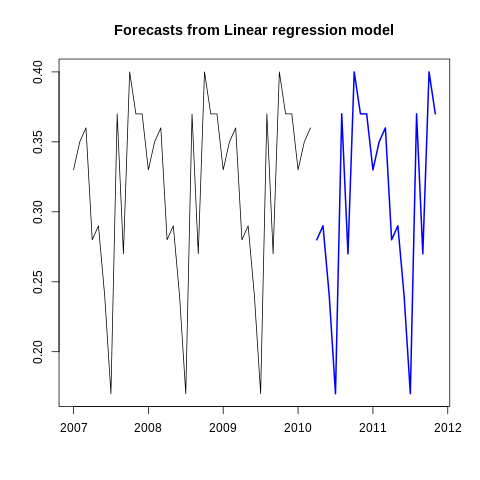

In [0]:
%%R
forecastfit2 <- forecast(fit2, h=20) # Monthly
plot(forecastfit2)

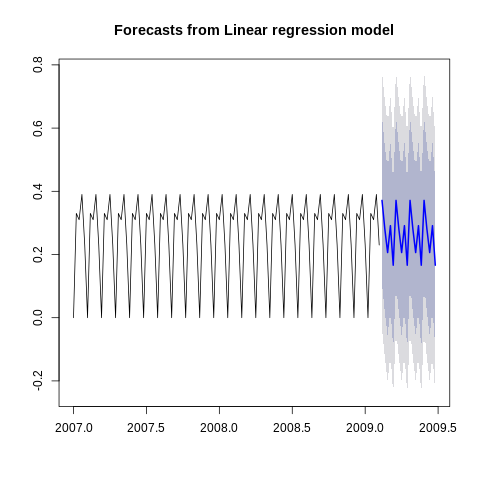

In [0]:
%%R
forecastfit3 <- forecast(fit3, h=20) # Weekly
plot(forecastfit3)

Decomposing Quarterly reading of Sub Meter 3

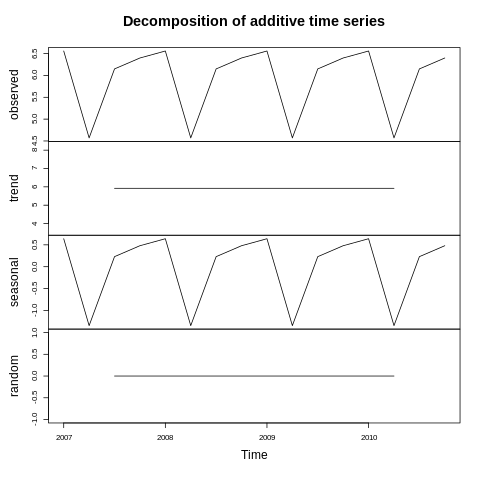

In [0]:
%%R
# Decompose Sub-meter 3 into trend, seasonal and remainder
componentsQuarterly <- decompose(Power_qtrTS)
plot(componentsQuarterly)


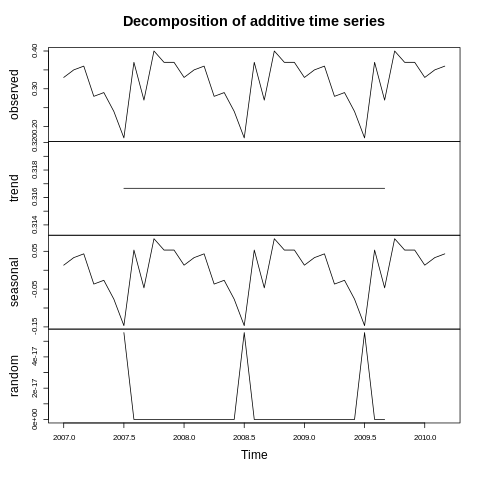

In [0]:
%%R
 # Decompose Sub-meter 3 into trend, seasonal and random (Monthly)
componentsmonthly <- decompose(Power_mthTS)
plot(componentsmonthly)

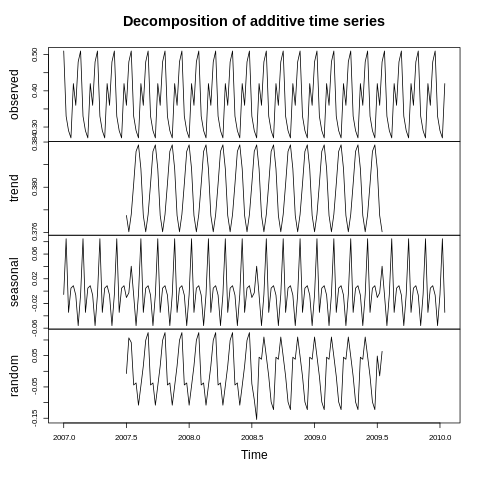

In [0]:
%%R
 # Decompose Sub-meter 3 into trend, seasonal and random (weekly)
componentsweekly <- decompose(Power_weekTS)
plot(componentsweekly)


HoltWinter Forecasting

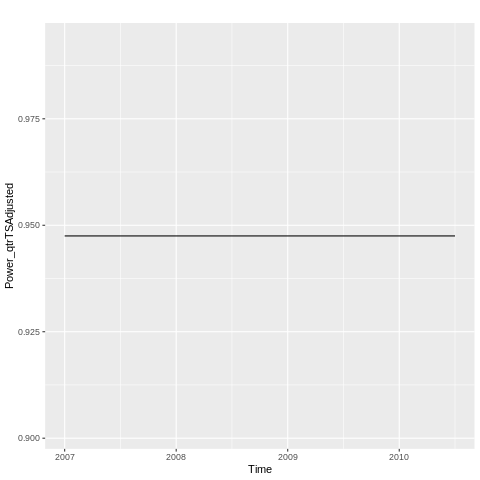

In [0]:
%%R
## Seasonal adjusting sub-meter 3 by subtracting the seasonal component & plot
Power_qtrTSAdjusted <- Power_qtrTS - componentsQuarterly$seasonal

autoplot(Power_qtrTSAdjusted)


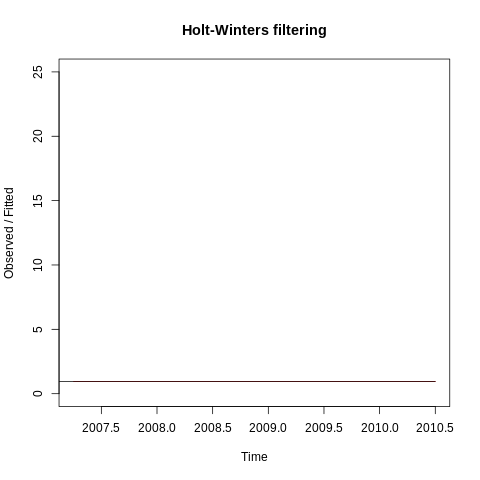

In [0]:
%%R
## Holt Winters Exponential Smoothing & Plot
tsSM3_HWQtr <- HoltWinters(Power_qtrTSAdjusted, beta=FALSE, gamma=FALSE)
plot(tsSM3_HWQtr, ylim = c(0, 25))

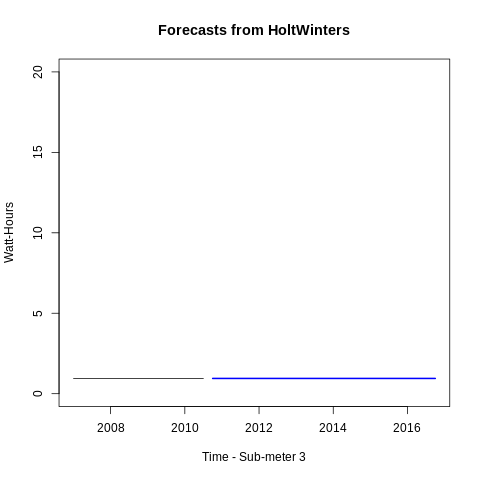

In [0]:
%%R
## HoltWinters forecast & plot
tsSM3_HWQtrfor <- forecast(tsSM3_HWQtr, h=25)
plot(tsSM3_HWQtrfor, ylim = c(0, 20), ylab= "Watt-Hours", xlab="Time - Sub-meter 3")

**Visualize and Analyze Energy Data using Granularization

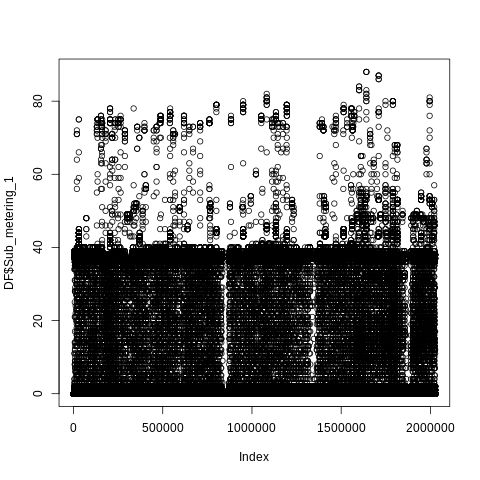

In [0]:
%%R
plot(DF$Sub_metering_1) # Without Granularization


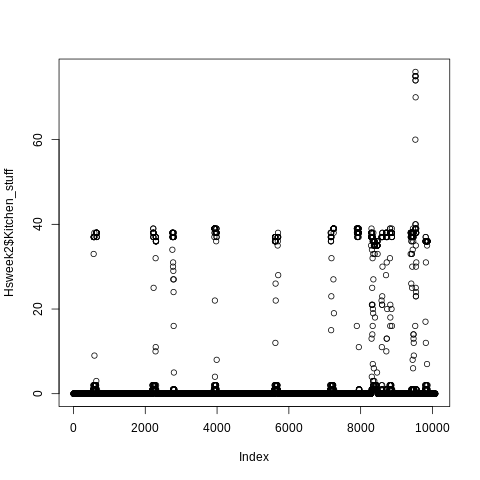

In [0]:
%%R
#Converting "DateTime" into PoSixlt format as Year, Month, Week, Day and Minute

year <- year(newDF$DateTime)

month <- month(newDF$DateTime)

week <- week(newDF$DateTime)

day <- day(newDF$DateTime)

minute <- minute(newDF$DateTime)

hour<- hour(newDF$DateTime)

# Granularity of year 2008 by week
Hsweek2 <- filter(newDF, year== 2008, week==2)

plot(Hsweek2$Kitchen_stuff)




**Day visualization for 9th Jan 2008 **

In [0]:
%%R


houseDay9 <- filter(newDF, year == 2007 & month == 1 & day == 9)

summary(houseDay9)


    DateTime                   Kitchen_stuff       Laundry      
 Min.   :2007-01-09 00:00:00   Min.   : 0.000   Min.   : 0.000  
 1st Qu.:2007-01-09 05:59:45   1st Qu.: 0.000   1st Qu.: 0.000  
 Median :2007-01-09 11:59:30   Median : 0.000   Median : 0.000  
 Mean   :2007-01-09 11:59:30   Mean   : 1.172   Mean   : 2.106  
 3rd Qu.:2007-01-09 17:59:15   3rd Qu.: 0.000   3rd Qu.: 1.000  
 Max.   :2007-01-09 23:59:00   Max.   :39.000   Max.   :72.000  
                                                                
  w_heater_AC     Global_active_power         Date            Time     
 Min.   : 0.000   Min.   :  3.367     2007-01-09:1380   00:00:00:   1  
 1st Qu.: 0.000   1st Qu.:  5.033     2007-01-08:  60   00:01:00:   1  
 Median : 0.000   Median : 20.733     2006-12-16:   0   00:02:00:   1  
 Mean   : 6.799   Mean   : 20.728     2006-12-17:   0   00:03:00:   1  
 3rd Qu.:17.000   3rd Qu.: 26.950     2006-12-18:   0   00:04:00:   1  
 Max.   :19.000   Max.   :144.500     2006-12-19

In [0]:
%%R
# Creating a plot using the Plotly Package for visualization

W <- plot_ly(houseDay9, x = ~houseDay9$DateTime, y = ~houseDay9$Kitchen_stuff, type = 'scatter', mode = 'lines')

chart_link = api_create(W, filename="line-basic")
chart_link



In [0]:
%%R
## Plot sub-meter 1, 2 and 3 with title, legend and labels - All observations 
Z <- plot_ly(houseDay9, x = ~houseDay9$DateTime, y = ~houseDay9$Kitchen_stuff, 
        name = 'Kitchen', type = 'scatter', mode = 'lines') %>%
 add_trace(y = ~houseDay9$Laundry, name = 'Laundry Appliance', mode = 'lines') %>%
 add_trace(y = ~houseDay9$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption January 9th, 2007",
 xaxis = list(title = "Time"),
 yaxis = list (title = "Power (watt-hours)"))

chart_link = api_create(Z, filename="line-basic1")
chart_link


In [0]:
%%R
## The higher the granularity of data, the clearer understanding of the data. Let reduce the granularity of the data by minutes.
## Subset the 9th day of January 2008 - 10 Minute frequency

houseDay9 <- filter(newDF, year == 2007 & month == 1 & day == 9 &
                     (minute == 0 | minute == 10 | minute == 20 | minute == 30 | minute == 40 | minute == 50))



In [0]:
%%R
# Plotly chart showing Minutes of Power consumption
Zz <- plot_ly(houseDay9, x = ~houseDay9$DateTime, y = ~houseDay9$Kitchen_stuff, name = 'Kitchen Appliance', type = 'scatter', mode = 'lines') %>%
 add_trace(y = ~houseDay9$Laundry, name = 'Laundry Appliance', mode = 'lines') %>%
 add_trace(y = ~houseDay9$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption January 9th, 2007",
 xaxis = list(title = "Time"),
 yaxis = list (title = "Power (watt-hours)"))

chart <- api_create(Zz, filename ="Minute")
chart

**Week Visualization( April of 2010) **

In [0]:
%%R
#Create a visualization with plotly for a Week of your choosing. 
#Use all three sub-meters and make sure to label. Experiment with granularity.
# Creating Vector containing Year and month 
Houseweek4 <- filter(newDF, year== 2010 & week==4)




# Showing a plotly graph of the Dataset created
Week4 <-plot_ly(Houseweek4, x = ~Houseweek4$DateTime, y = ~Houseweek4$Kitchen_stuff, type = 'scatter', mode = 'lines')
chart_link = api_create(Week4, filename= "Week Power Consumption")
chart_link



In [0]:
%%R
write.csv(Houseweek4,'week4.csv')

In [0]:
%%R
# Sub-meters Power comsumption on Jan 23th 2010.
meters_week4 <- plot_ly(Houseweek4, x = ~Houseweek4$DateTime, y = ~Houseweek4$Kitchen_stuff, 
        name = 'Kitchen', type = 'scatter', mode = 'lines') %>%
        add_trace(y = ~Houseweek4$Laundry, name = 'Laundry Appliance', mode = 'lines') %>%
        add_trace(y = ~Houseweek4$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption Week 4, 2010",
 xaxis = list(title = "Year"),
 yaxis = list (title = "Power (watt-hours)"))

chart_link = api_create(meters_week4, filename="Power Meters~Consumption1")
chart_link

Minute Visualization and Analysis - week 4,2010 (Granularity Adjusted)

In [0]:
%%R
Week4Minute <- filter(newDF, year == 2010 & week == 4 &
                     (minute == 0 | minute == 10 | minute == 20 | minute == 30 | minute == 8 | minute == 40))


In [0]:
%%R
Week4Minute10 <- plot_ly(Week4Minute, x = ~Week4Minute$DateTime, y = ~Week4Minute$Kitchen_stuff, 
        name = 'Kitchen', type = 'scatter', mode = 'lines') %>%
        add_trace(y= ~Week4Minute$Laundry, name = 'Laundry App', mode = 'lines')  %>%
 add_trace(y = ~Week4Minute$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption Jan 23-27, 2010",
 xaxis = list(title = "Year"),
 yaxis = list (title = "Power (watt-hours)"))

chart_link = api_create(Week4Minute10, filename=" Minute Meters~Consumption")
chart_link

**Day Visualization and Analysis - Day 24 of January 2010**

In [0]:
%%R
Day24 <- filter(newDF, year== 2010 & month==1 & day==24)

Wz<- plot_ly(Day24, x = ~Day24$DateTime, y = ~Day24$Kitchen_stuff, type = 'scatter', mode = 'lines')

chart_link = api_create(Wz, filename="line-basic")
chart_link




In [0]:
%%R
Day_24 <- plot_ly(Day24, x = ~Day24$DateTime, y = ~Day24$Kitchen_stuff, 
        name = 'Kitchen', type = 'scatter', mode = 'lines') %>%
        add_trace(y = ~Day24$Laundry, name = 'Laundry Room', mode = 'lines') %>%
        add_trace(y = ~Day24$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption Jan 24th, 2010",
 xaxis = list(title = "Year"),
 yaxis = list (title = "Power (watt-hours)"))

chart_link = api_create(Day_24, filename="Day~24-2010-Power~Consumption1")
chart_link

**Minute Visualization and Analysis - January 24th (Granularity Adjusted**)

In [0]:
%%R
D24 <- filter(newDF, year== 2010 & month==1 & day==24 &
                     (minute == 0 | minute == 10 | minute == 20 | minute == 30 | minute == 8 | minute == 40))

DW <- plot_ly(D24, x = ~D24$DateTime, y = ~D24$Sub_Kitchen_stuff, 
        name = 'Kitchen', type = 'scatter', mode = 'lines') %>%
        add_trace(y = ~D24$Laundry, name = 'Laundry Room', mode = 'lines') %>%
        add_trace(y = ~D24$w_heater_AC, name = 'Water Heater & AC', mode = 'lines') %>%
 layout(title = "Power Consumption Jan 24th, 2010",
 xaxis = list(title = "Year"),
 yaxis = list (title = "Power (watt-hours)"))

chart_link = api_create(DW, filename="Day~24~2010~MinutePower~Consumption1")
chart_link



**preparing data for Time Series Analysis**

**Create TS object with SubMeter3**

In [0]:
%%R
tshouseday2

In [0]:
%%R
str(tshouseday2)

 Time-Series [1:169] from 2007 to 2010: -1 0 -17 17 -17 0 16 -16 18 -1 ...


Creating a plot for time series for Meter 1

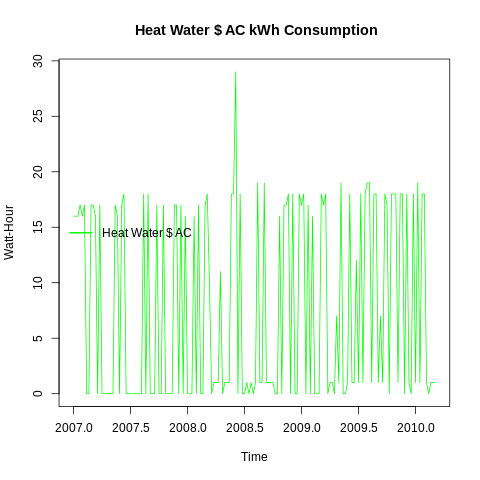

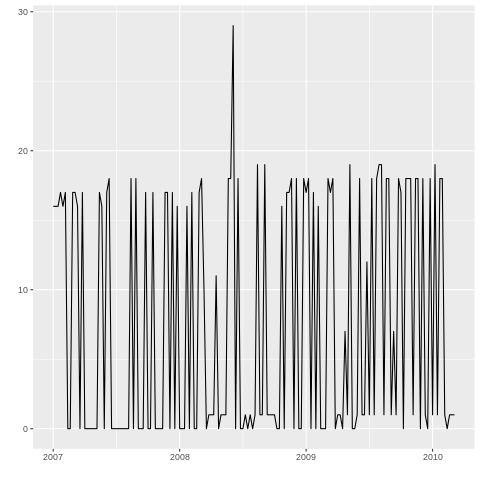

In [0]:
%%R
Week1 <- filter(newDF, wday==1 & hour==20 & minute== 1)

Ts_Week1 <- ts(Week1$w_heater_AC, frequency=52, start=c(2007,1))

plot(Ts_Week1, 
     plot.type='s',
     start=c(2007,1),
     col=c('green'),
     main=' Heat Water $ AC kWh Consumption',
     xlab='Time', ylab = 'Watt-Hour')


label <- c('Heat Water $ AC')
legend('left', label, col=c('green'), lwd=2, bty='n')

autoplot(Ts_Week1)



In [0]:
%%R
Ts_Week1

**Time Series for Meter 2**

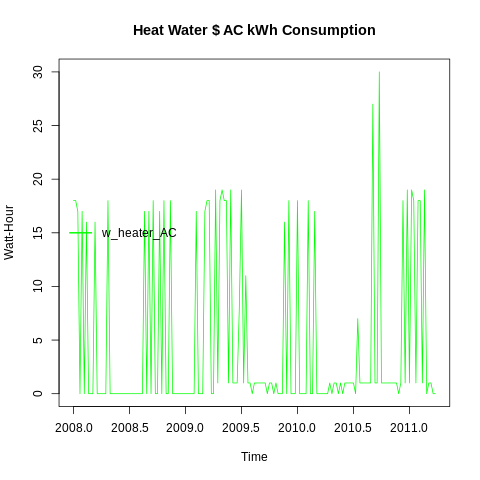

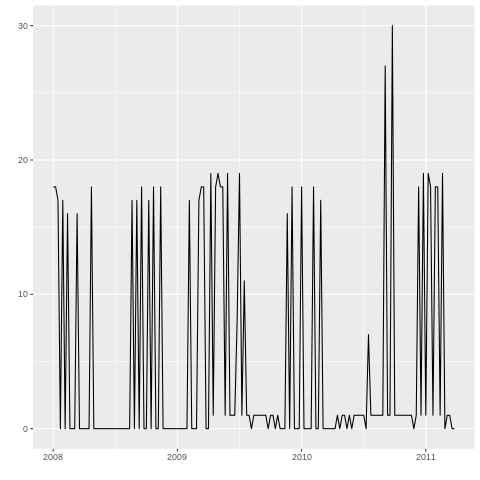

In [0]:
%%R
week3 <- filter(newDF, wday==3 & hour==20 & minute== 1)

Ts_week3 <- ts(week3$w_heater_AC , frequency=52, start=c(2008,1))


plot(Ts_week3, 
     plot.type='s',
     start=c(2008,1),
     col=c('green'),
     main='Heat Water $ AC kWh Consumption',
     xlab='Time', ylab = 'Watt-Hour')


label <- c('w_heater_AC')
legend('left', label, col=c('green'), lwd=2, bty='n')

autoplot(Ts_week3)

Forecasting and visualizing using ARIMA

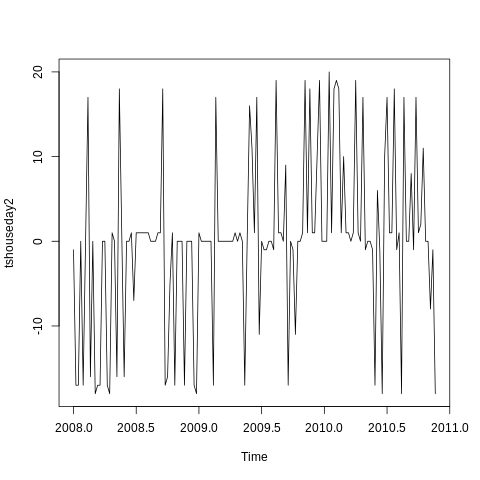

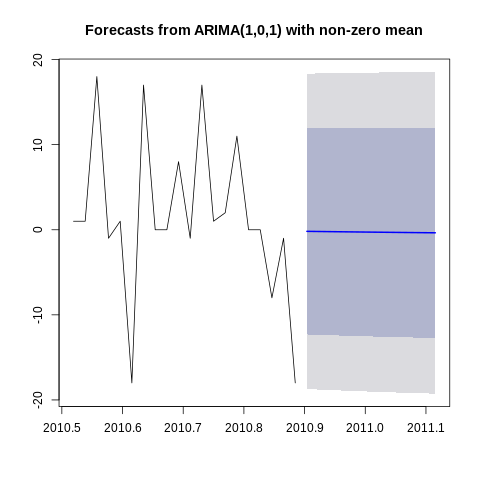

In [0]:
%%R
houseday2 <- filter(newDF,  wday == 2 & hour == 20 & minute == 1)

houseday2$w_heater_AC<- ts(houseday2$w_heater_AC, frequency=52, start=c(2007,1))

tshouseday2 <- diff(houseday2$w_heater_AC, 52) # Create year on year time series for monthly diff

#Estimating AR Model
fit_diff_ar<- arima(tshouseday2, order=c(1,0,1))

#Forecasting
fitweek2_arf<- forecast(fit_diff_ar, h=12)

#print(fitweek2_arf)

plot(tshouseday2)

plot(fitweek2_arf, include=20)

In [0]:
# Summary of the analysis

**Conculsions**

Clients save energy and money from the first year with the use of the submeters.

With the data analysis of the submeters clients will be able to:

    **Past Consumption:**
        Check energy evolution by different submeter over different periods of time
        Check the costs of any period of time
    **Future predictions:**
        Predict their bills by months ( total energy or submeters)
        Predict their energy expenses over the years
**bold text**